In [1]:
cd ..

/Users/quentin/Documents/DLAV/translating-images-into-maps-main


In [2]:
%matplotlib inline

In [3]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import cv2

In [4]:
from src.data.dataloader import nuScenesMaps, read_split

from argslib import parse_args, init
from visualization import color_components, make_composite, plot_ground_truth, COLOR_MAP, color_map_labels

In [5]:
import torch

In [7]:
args = parse_args(notebook=True)
# args.
init(args)

In [7]:
val_data = nuScenesMaps(
        root=args.root,
        split=args.val_split,
        grid_size=args.grid_size,
        grid_res=args.grid_res,
        classes=args.load_classes_nusc,
        dataset_size=args.data_size,
        desired_image_size=args.desired_image_size,
        mini=True,
        gt_out_size=(100, 100),
    )

/Users/deepakduggirala/miniforge3/envs/tim/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
res_200 = torch.load('notebooks/ckpt-30-val-pred-200x200.pt')
res_100 = torch.load('notebooks/cktp-30-val-pred-100x100.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/ckpt-30-val-pred-200x200.pt'

In [10]:
res_200.shape, res_100.shape

(torch.Size([80, 14, 200, 200]), torch.Size([80, 14, 100, 100]))

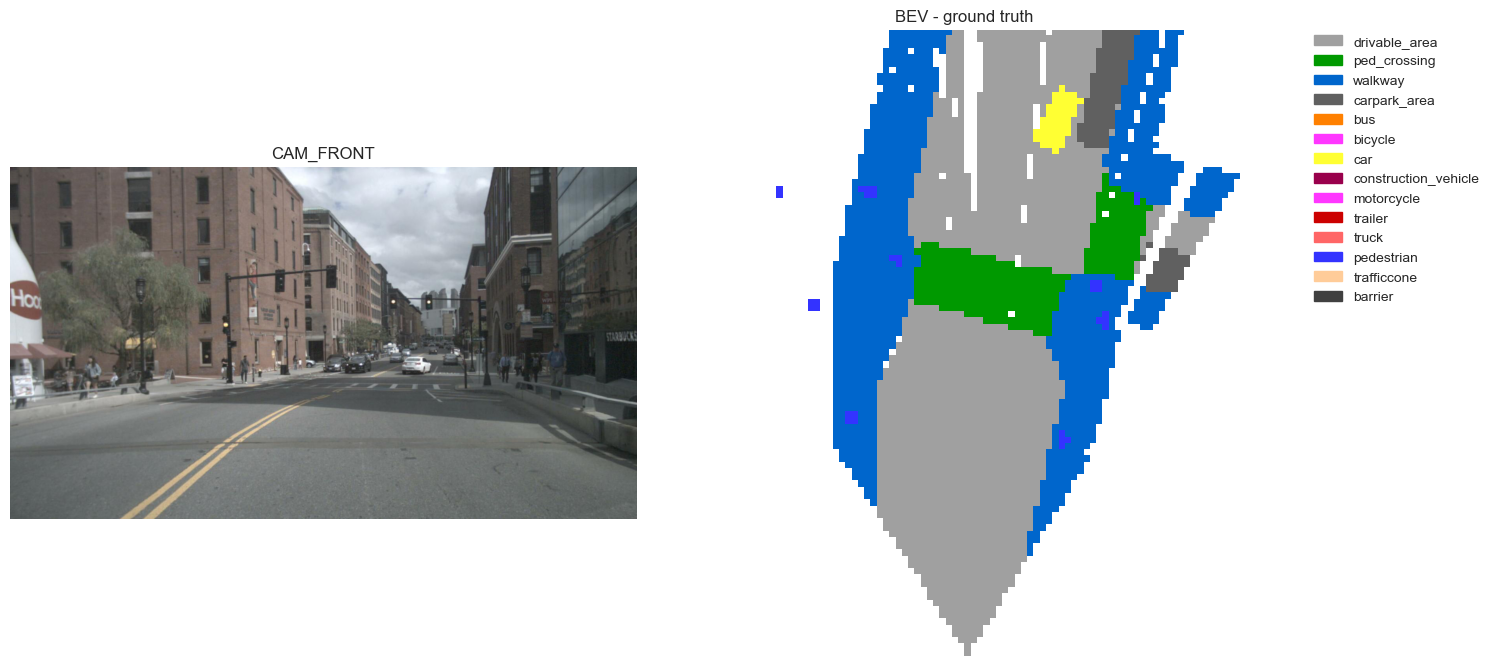

In [14]:
i_sample = 0
image, cls_maps, vis_mask, calib, grid2d = val_data.__getitem__(0)
plot_ground_truth(image, cls_maps)

In [40]:
def visualize_prediction(gt_image, cls_maps, pred, out_path=None, figsize=(15, 7), dpi=300):
    composite = make_composite(cls_maps)
    cls_maps_colors = cv2.flip(color_components(composite.numpy()), 0)
    gt_image_np = gt_image.numpy().transpose((1, 2, 0))  # (3. 900, 1600) -> (1600, 900, 3)
    
    composite_pred = make_composite(pred)
    pred_colors = cv2.flip(color_components(composite_pred.numpy()), 0)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    ax = axs[0][0]
    ax.imshow(gt_image_np)
    ax.set_title('CAM_FRONT')
    ax.axis('off')

    ax = axs[1][0]
    ax.imshow(cls_maps_colors)
    ax.set_title('BEV - ground truth')
    legend_colors = [np.append(c / 255, 1) for c in COLOR_MAP.values()]
    patches = [mpatches.Patch(color=legend_colors[i], label=label)
               for i, label in enumerate(color_map_labels.keys())]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.axis('off')
    
    ax = axs[1][1]
    ax.imshow(pred_colors)
    ax.set_title('BEV - prediction')
    legend_colors = [np.append(c / 255, 1) for c in COLOR_MAP.values()]
    patches = [mpatches.Patch(color=legend_colors[i], label=label)
               for i, label in enumerate(color_map_labels.keys())]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.axis('off')

    # access each axes object via axs.flat
    for ax in axs.flat:
        # check if something was plotted
        if not bool(ax.has_data()):
            fig.delaxes(ax)  # delete if nothing is plotted in the axes obj

    fig.tight_layout()
    if out_path:
        fig.savefig(out_path, dpi=dpi)
    else:
        plt.show()

In [34]:
res_100.shape

torch.Size([80, 14, 100, 100])

In [49]:
i_sample = 10
image, cls_maps, vis_mask, calib, grid2d = val_data.__getitem__(i_sample)
pred = res_100[i_sample]

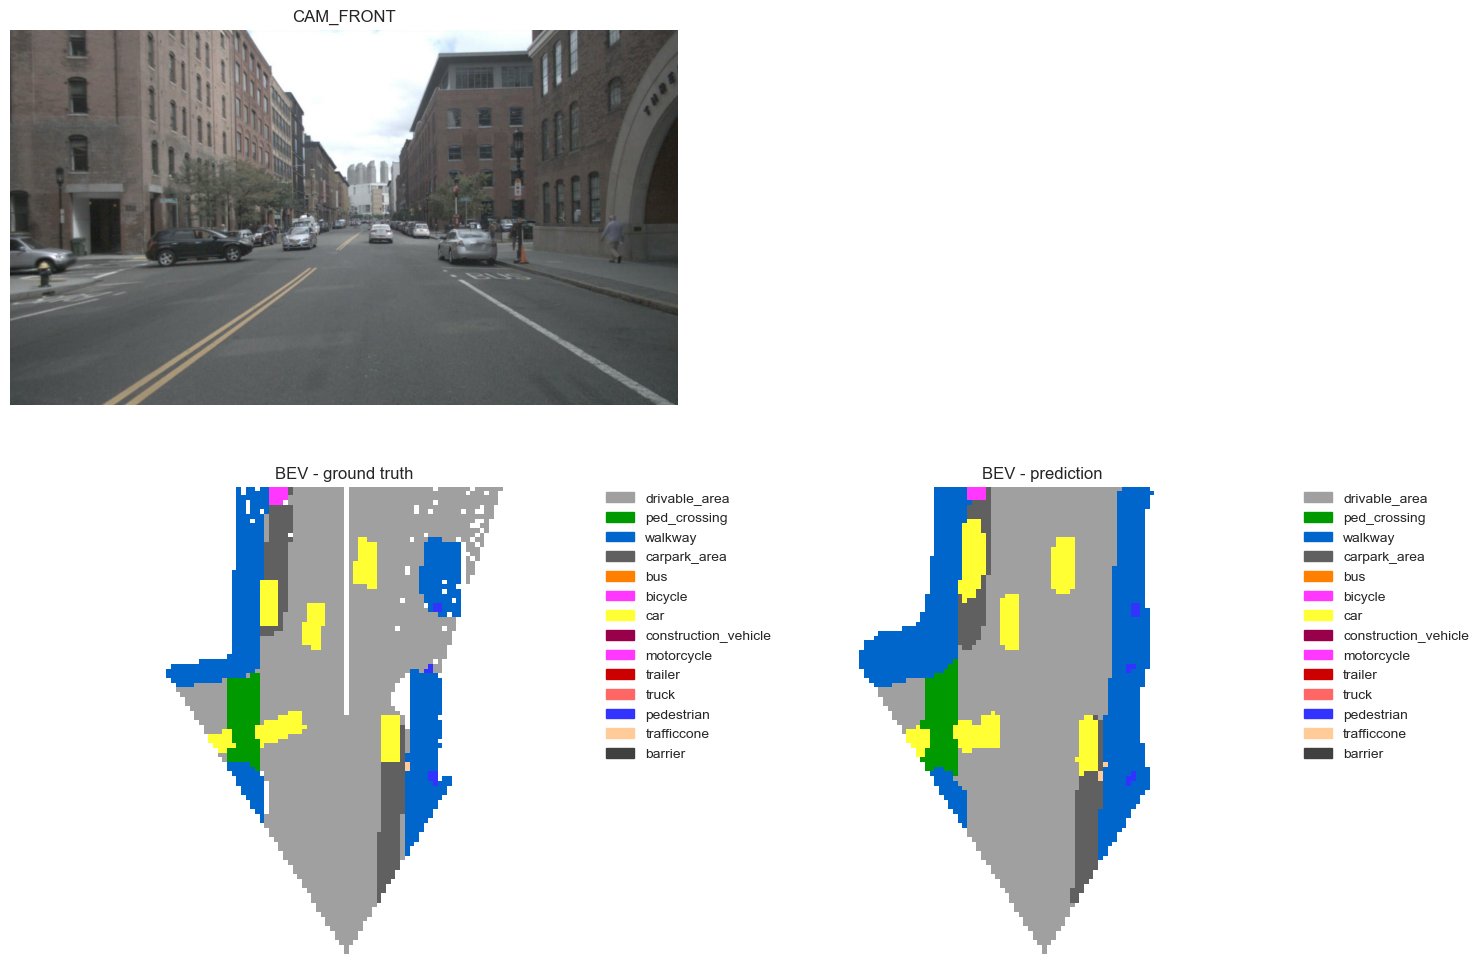

In [50]:
visualize_prediction(image, cls_maps, pred, figsize=(15, 10))